In [1]:
import os
import numpy as np

import torch

import torch.nn as nn

from torch.utils.data import DataLoader
from torch.utils.data import Dataset

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['DejaVu Serif']

from utils import *

/home/sgagnon/anaconda3/envs/ddpm/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# files = [ "snapshot_110.hdf5", "snapshot_115.hdf5" , "snapshot_100.hdf5", "snapshot_105.hdf5" ]
files = [ "../snapshot_110.hdf5"]

In [3]:
# initialize training dataset arrays
pos_arr = []
rad_arr = []
dens_arr = []
mass_arr = []
vol_arr = []
gpot_arr = []
pres_arr = []
mag_arr = []
Babs_arr = []
encr_arr = [] # is this supposed to be a target array?
# target array
slope_arr = []

for filename in files:

    # open file
    f = h5py.File(filename)
    #if filename == files[0]:
    #    for k in f["PartType0"].keys():
    #        print(k)
    
    # read units from file
    UnitM, UnitL, UnitV, BoxSize = read_units(filename)
    U = compute_arepo_units(UnitM, UnitL, UnitV, False)
    
    # read momenta
    pf, pi = read_momentum_bins(filename)
    #print(pi)
    
    BoxCtr = BoxSize*U["UnitLength"]/2.

    # get full data and convert it to cgs
    
    # positions
    pos  = np.array(f[u'PartType0/Coordinates']).astype(np.float64)*U["UnitLength"]-BoxCtr
    rad  = np.sqrt(np.sum(pos**2,axis=1))

    # pos_arr += list(pos)
    rad_arr += list(rad)

    # density, mass and volume
    dens = np.array(f[u'PartType0/Density']).astype(np.float64)*U["UnitDensity"]
    mass = np.array(f[u'PartType0/Masses'])*U["UnitMass"]
    volu = mass/dens

    dens_arr += list(dens)
    mass_arr += list(mass)
    vol_arr += list(volu)

    # gravitational potential
    gpot = np.array(f[u'PartType0/Potential']).astype(np.float64)*U["UnitPotential"]

    gpot_arr += list(gpot)

    # thermal pressure
    pres = np.array(f[u'PartType0/Pressure']).astype(np.float64)*U["UnitPressure"]

    pres_arr += list(pres)

    # magnetic field vector
    mag  = np.array(f[u'PartType0/MagneticField']).astype(np.float64)*U["UnitBfield"]
    Babs = np.sqrt(np.sum(mag**2,axis=1))

    mag_arr += list(mag)
    Babs_arr += list(Babs)
    
    # total CR energy density
    cren = np.array(f[u'PartType0/CosmicRaySpecificEnergy']).astype(np.float64)*U["UnitEspecific"]
    encr = cren*dens

    encr_arr += list(encr)
    
    # CR spectrum amplitude
    crspec = np.array(f[u'PartType0/CRspecEnergy']).astype(np.float64)
    
    # CR sprectral slope
    slope  = np.log(crspec[:,-1]/crspec[:,-2]) / np.log(pi[-1]/pi[-2])

    slope_arr += list(slope)

# put em in numpy
# training dataset arrays
pos_arr = np.asarray(pos_arr)
rad_arr = np.asarray(rad_arr)
dens_arr = np.asarray(dens_arr)
mass_arr = np.asarray(mass_arr)
vol_arr = np.asarray(vol_arr)
gpot_arr = np.asarray(gpot_arr)
pres_arr = np.asarray(pres_arr)
mag_arr = np.asarray(mag_arr)
Babs_arr = np.asarray(Babs_arr)
encr_arr = np.asarray(encr_arr)
# target array
slope_arr = np.asarray(slope_arr)

reading file:  snapshot_110.hdf5
reading file:  snapshot_110.hdf5


In [4]:
idcs = np.where(dens_arr > 1e-29)
np.random.shuffle(idcs[0]) # remove correlations between neighboring cells
train_end_idx = int(len(idcs[0])*0.7)

dataset = {"source": np.log10(np.stack([rad_arr[idcs], dens_arr[idcs], Babs_arr[idcs], encr_arr[idcs]])),
            "target": slope_arr[idcs]}

In [5]:
for src in dataset["source"]:
    src -= src.min()
    src /= src.max()

dataset["target"] -= dataset["target"].min()
dataset["target"] /= dataset["target"].max()

In [6]:
training_dataset = {"source": dataset["source"][:,:train_end_idx],\
                    "target": dataset["target"][:train_end_idx]}

testing_dataset = {"source": dataset["source"][:,train_end_idx:],\
                    "target": dataset["target"][train_end_idx:]}

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.lin1 = nn.Linear(4, 100, dtype=torch.float32)
        self.tanh1 = nn.Sigmoid()

        # self.lin2 = nn.Linear(8, 16, dtype=torch.float32)
        # self.tanh2 = nn.Sigmoid()
        
        self.lin3 = nn.Linear(100, 1, dtype=torch.float32)
        self.tanh3 = nn.Sigmoid()
    def forward(self, x):
        x = self.lin1(x)
        x = self.tanh1(x)
        # x = self.lin2(x)
        # x = self.tanh2(x)
        x = self.lin3(x)
        x = self.tanh3(x)
        return x

model = MLP().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, 10, 1)

In [8]:
batch_size = 2048
epochs = 1000
n_batches_training = training_dataset["source"].T.shape[0] // batch_size
n_batches_testing = testing_dataset["source"].T.shape[0] // batch_size
losses = []
val_loss = []

model.train()
for epoch in range(epochs):
    for i in range(n_batches_training):
        optimizer.zero_grad()
        x = training_dataset["source"][:,i*batch_size:(i+1)*batch_size].T
        y = training_dataset["target"][i*batch_size:(i+1)*batch_size]
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        x = x.to(device)
        y = torch.unsqueeze(y, -1)
        y = y.to(device)

        output = model(x)
        loss = torch.mean((output - y)**2)
        loss.backward()
        losses.append(loss.item())

        optimizer.step()
        scheduler.step()

        if i % 40 == 0:
            print('\tEpoch %d | Batch %d | Training Loss %6.2f' % (epoch, i, loss.item()))
    
    for i in range(n_batches_testing):
        x = testing_dataset["source"][:,i*batch_size:(i+1)*batch_size].T
        y = testing_dataset["target"][i*batch_size:(i+1)*batch_size]
        x = torch.tensor(x, dtype=torch.float32)
        y = torch.tensor(y, dtype=torch.float32)
        x = x.to(device)
        y = torch.unsqueeze(y, -1)
        y = y.to(device)

        output = model(x)
        loss = torch.mean((output - y)**2)

        val_loss += [loss.item()]
        # target_outputs += list(output.T[0].cpu().detach().numpy())
        # target_truth += list(y.cpu().detach().numpy())

        if i % 40 == 0:
            print('\tEpoch %d | Batch %d | Validation Loss %6.2f' % (epoch, i, loss.item()))
    print('Epoch %d | Training Loss %6.2f' % (epoch, sum(losses)/len(losses)))
    print('Epoch %d | Validation Loss %6.2f' % (epoch, sum(val_loss)/len(val_loss)))


	Epoch 0 | Batch 0 | Training Loss   0.10
	Epoch 0 | Batch 40 | Training Loss   0.09
	Epoch 0 | Batch 80 | Training Loss   0.08
	Epoch 0 | Batch 120 | Training Loss   0.07
	Epoch 0 | Batch 160 | Training Loss   0.06
	Epoch 0 | Batch 200 | Training Loss   0.05
	Epoch 0 | Batch 240 | Training Loss   0.05
	Epoch 0 | Batch 280 | Training Loss   0.05
	Epoch 0 | Batch 0 | Validation Loss   0.05
	Epoch 0 | Batch 40 | Validation Loss   0.04
	Epoch 0 | Batch 80 | Validation Loss   0.05
	Epoch 0 | Batch 120 | Validation Loss   0.04
Epoch 0 | Training Loss   0.06
Epoch 0 | Validation Loss   0.05
	Epoch 1 | Batch 0 | Training Loss   0.05
	Epoch 1 | Batch 40 | Training Loss   0.04
	Epoch 1 | Batch 80 | Training Loss   0.04
	Epoch 1 | Batch 120 | Training Loss   0.04
	Epoch 1 | Batch 160 | Training Loss   0.04
	Epoch 1 | Batch 200 | Training Loss   0.04
	Epoch 1 | Batch 240 | Training Loss   0.04
	Epoch 1 | Batch 280 | Training Loss   0.04
	Epoch 1 | Batch 0 | Validation Loss   0.04
	Epoch 1 | Batch

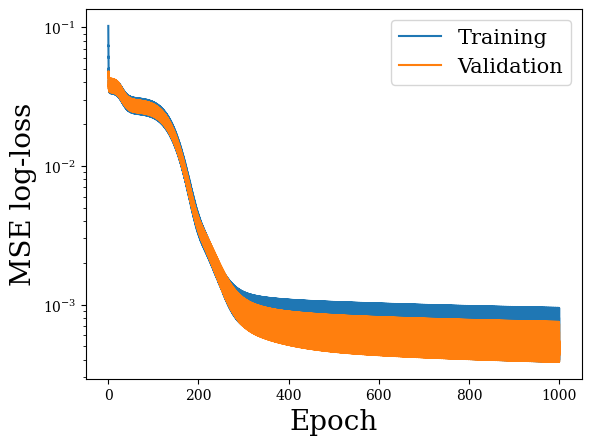

<Figure size 640x480 with 0 Axes>

In [88]:
plt.plot(np.linspace(0, epochs, len(losses)), losses, label="Training")
plt.plot(np.linspace(0, epochs, len(val_loss)), val_loss, label="Validation")
plt.ylabel("MSE log-loss", fontsize=20)
plt.xlabel("Epoch", fontsize=20)
plt.legend(loc="upper right", fontsize=15)
plt.yscale("log")
plt.show()

plt.savefig("./loss_curve.pdf")

In [14]:
rad = testing_dataset["source"][0]
dens = testing_dataset["source"][1]
Babs = testing_dataset["source"][2]
encr = testing_dataset["source"][3]
slope = testing_dataset["target"]
predicted_slope = model(torch.tensor(testing_dataset["source"].T, dtype=torch.float32).to(device)).cpu().detach().numpy()

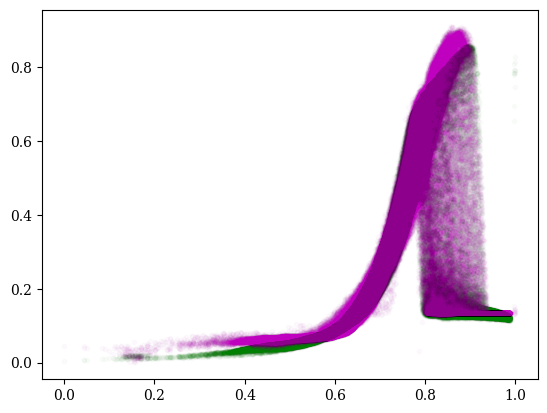

<Figure size 640x480 with 0 Axes>

In [93]:
plt.plot(rad, predicted_slope, 'g.', alpha=0.02)
plt.plot(rad, slope, 'm.', alpha=0.02)
# plt.plot(dens, predicted_slope, 'g.', alpha=0.02)
# plt.plot(dens, slope, 'm.', alpha=0.02)
# plt.plot(Babs, predicted_slope, 'g.', alpha=0.02)
# plt.plot(Babs, slope, 'm.', alpha=0.02)
# plt.plot(encr, predicted_slope, 'g.', alpha=0.02)
# plt.plot(encr, slope, 'm.', alpha=0.02)

# plt.plot(1000, 1000,'b.', label="Prediction")
# # plt.plot([0,1], [0,1], color='red', linestyle='--', label="Reference")
# plt.axhline(0, color='red', linestyle='--', label="Perfect")
# # plt.plot(slope.T[::100], predicted_slope.T[0][::100], 'b.', alpha=0.1)
# plt.plot(slope.T[::100], (predicted_slope.T[0]-slope.T)[::100], 'b.', alpha=0.1)
# plt.ylabel("Residual", fontsize=20)
# # plt.ylabel("Predicted Slope", fontsize=20)
# plt.xlabel("True Slope", fontsize=20)
# plt.xlim(0, 1)
# # plt.ylim(0, 1)
# plt.ylim(-0.15, 0.15)
# plt.legend(loc="upper left", fontsize=15)
plt.show()

plt.savefig("./slope_residuals.pdf")

In [75]:
(predicted_slope.T[0]-slope.T[0])[::1000]

array([ 0.01533026, -0.09317164,  0.07764612,  0.24760722,  0.09719799,
       -0.08726634, -0.20231137, -0.10136826, -0.10566126, -0.08033785,
        0.34365845, -0.07342204, -0.11508676, -0.09615466, -0.05647072,
       -0.11734276,  0.05778848, -0.0825475 ,  0.01539035,  0.51936185,
       -0.10064353,  0.10819273, -0.08588037, -0.09309423,  0.04075627,
        0.37899572, -0.08480714, -0.08337086, -0.08085114,  0.09346624,
        0.02569263, -0.09115702, -0.16507754, -0.09313771, -0.08634068,
        0.43492132, -0.10510363, -0.10099135, -0.17101964,  0.06249185,
       -0.08993234, -0.12945822,  0.2939474 , -0.09150913, -0.09056275,
       -0.17915995, -0.08830021, -0.07952209, -0.08997546,  0.03045143,
       -0.11357652, -0.09561132, -0.1109589 ,  0.2376792 , -0.09033671,
       -0.09221609, -0.10251323, -0.08939242, -0.09989181, -0.09847704,
        0.47242534, -0.09087139, -0.08551657, -0.09006871,  0.04583211,
       -0.0877146 , -0.09046257,  0.37774056,  0.07428886,  0.40

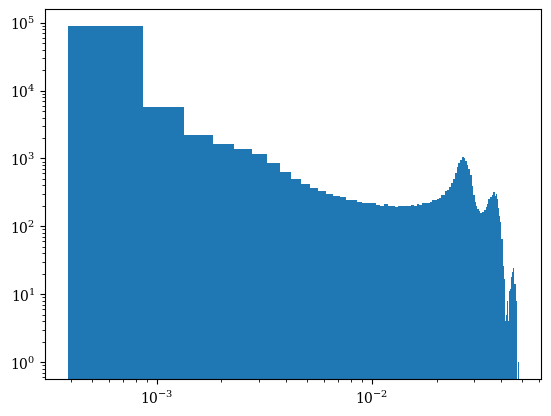

In [12]:
plt.hist(val_loss, 100)
plt.xscale("log")
plt.yscale("log")
plt.show()